In [1]:
# Utility functions
import pandas as pd
import numpy as np
from warnings import filterwarnings

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

# NLP
import nltk

# Feature extration 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


# Statistics
from scipy import stats

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Set a random seed
np.random.seed(42)

# magic line
%matplotlib inline
# Set theme
plt.style.use('ggplot')
#ignore warnings
filterwarnings('ignore')

# ================= Uncomment if stopwords throws and error ======================== # 

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

### This note book will contain the visualizations necessary to motivate intuition on the corpus
- tokinasation 
- stopword creation and removal
- Lexicon normalization

In [2]:
# Load dataframe 1
PATH = '../../src/data/dataframe1.csv'

df = pd.read_csv(PATH)
df.head()

,text,target
0,Bill Changing Credit Card Rules Is Sent to Oba...,0
1,"In Hollywood, the Easy-Money Generation Toughe...",0
2,1700 runners still unaccounted for in UK's Lak...,0
3,Yankees Pitchers Trade Fielding Drills for Put...,0
4,Large earthquake rattles Indonesia; Seventh in...,0


### Split the data into training and test sets

In [3]:
X = df.drop(columns=['target'])
y = df[['target']]
X.shape, y.shape
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25600, 1), (6400, 1), (25600, 1), (6400, 1))

Text(0, 0.5, 'Document Count')

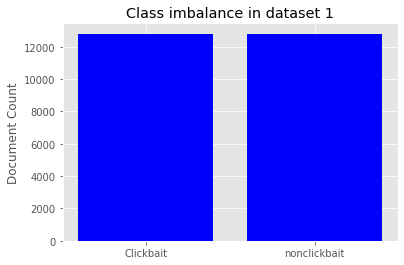

In [4]:
# Visualize the classes
plt.bar(x=['Clickbait', 'nonclickbait'], height=y_train.groupby(['target']).target.count(), color='b');
plt.title("Class imbalance in dataset 1")
plt.ylabel("Document Count")

### Visualize the class difference

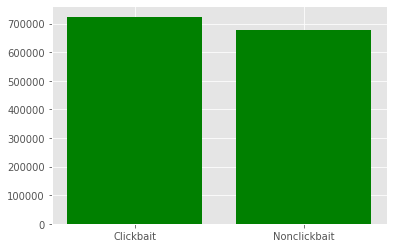

In [5]:
# Create a corpus of clickbait and nonclickbait

# join all of the messages from each class into their respective corpus
df = pd.concat([X_train, y_train], axis=1)
click = df[df.target == 1]
non = df[df.target == 0]

# Create large strings of each
click_corpus = " ".join(click.text.to_list())
non_corpus = " ".join(non.text.to_list())

plt.bar(x=['Clickbait', 'Nonclickbait'], height=[len(click_corpus), len(non_corpus)], color = 'g');

click bait corpus just seems a little bit longer than the non-clickbait corpus. Let's see of the overlapping histograms of each titles length reveals anything

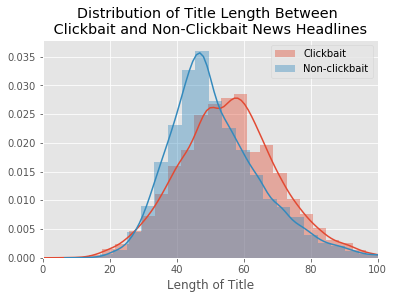

In [6]:
def get_len(string):
    return len(string)

click_len = click.text.apply(get_len)
non_len = non.text.apply(get_len)

fig, ax = plt.subplots()
for a, b in zip([click_len, non_len], ['Clickbait', 'Non-clickbait']):
    sns.distplot(a, bins=30, ax=ax, kde=True, label=b)
    plt.legend()
ax.set_xlim([0, 100])
ax.set_xlabel("Length of Title")
ax.set_title("Distribution of Title Length Between \n Clickbait and Non-Clickbait News Headlines ");

It seems that clickbait titles are slightly longer on average. I will conduct a students ttest between the two groups to see if there is significance 

In [7]:
# test for normality:
stats.normaltest(non_len), stats.normaltest(click_len)

(NormaltestResult(statistic=1866.1603570633722, pvalue=0.0),
 NormaltestResult(statistic=85.52377864217378, pvalue=2.683783213192833e-19))

Despite looking very normal, the distributions are not normal. 

In [8]:
significance = stats.mannwhitneyu(click_len, non_len)
mean_dif = int(round((click_len.mean()-non_len.mean()), 0))
print(f"Clickbait titles are on Average {mean_dif} words longer than non clickbait titles with a p value of {significance[1]}")

Clickbait titles are on Average 4 words longer than non clickbait titles with a p value of 2.0717424030770497e-138


Next, let's look at the bag of words represented by each class. To do that, first, I will tokenise each of the bag of words and then create a frequency dictionary of each class and plot the results.

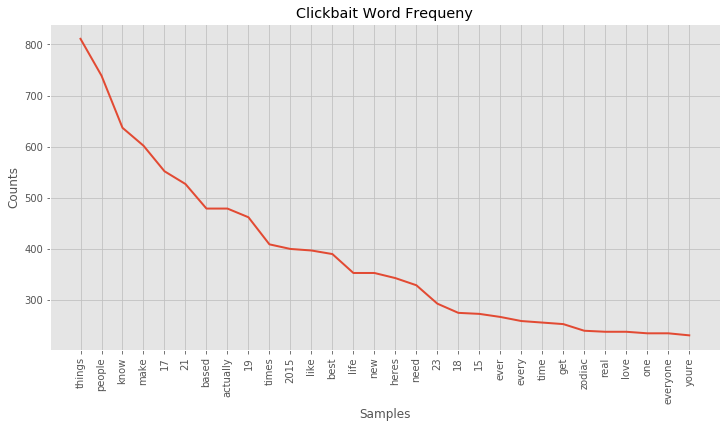

In [9]:
# Tokenizer 
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
click_tokenized = tokenizer.tokenize(click_corpus)
non_tokenized = tokenizer.tokenize(non_corpus)

# Lower case and remove stopwords
stop_words=set(stopwords.words("english"))

fil_click = [word.lower() for word in click_tokenized if word.lower() not in stop_words]
fil_non = [word.lower() for word in non_tokenized if word.lower() not in stop_words]

# Freq Dict
click_dict = FreqDist(fil_click)
non_dict = FreqDist(fil_non)

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

click_dict.plot(30, title="Clickbait Word Frequeny")

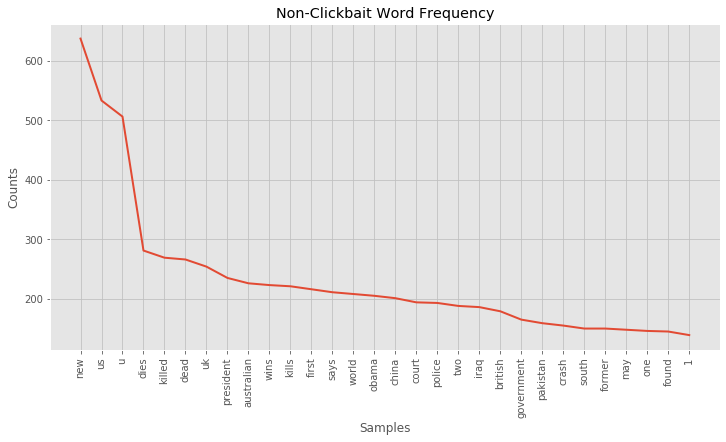

In [10]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

non_dict.plot(30, title="Non-Clickbait Word Frequency");

The composition of the words are very different. I really think a naive bayes would work for this right out of the gate. However, i have more questions about the corpus.

As an aside, I should look into removing all proper nouns from the corpus in order to increase the generalizability of the model. Obama, Trump place names too. These are all things that are relevant at the time of making the model but in the coming years will be less and less important.

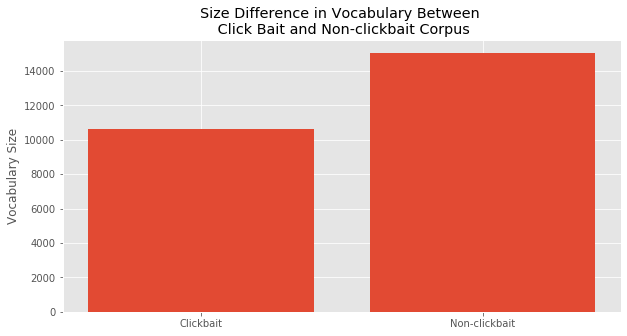

In [11]:
# Vocabulary check
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(x=["Clickbait", "Non-clickbait"], height=[len(click_dict), len(non_dict)])
ax.set_ylabel("Vocabulary Size")
plt.title("Size Difference in Vocabulary Between \n Click Bait and Non-clickbait Corpus");

## Considering the difference in Vocabulary Sizes, I am interested in Visualizing those differences using word clouds

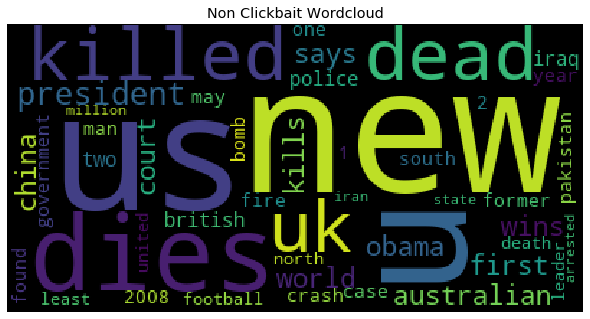

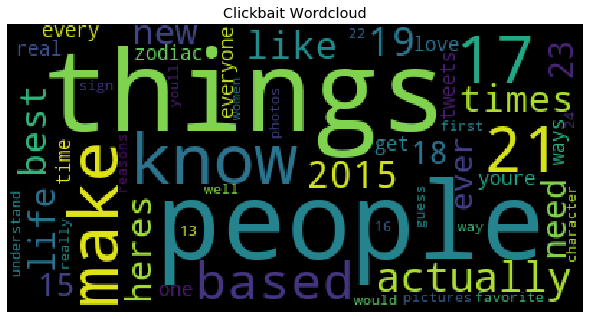

In [12]:
wordcloud  = WordCloud(min_font_size=10).generate_from_frequencies(non_dict)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title("Non Clickbait Wordcloud")
plt.tight_layout(pad = 0) 
  
plt.show() 

wordcloud  = WordCloud(min_font_size=10).generate_from_frequencies(click_dict)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title("Clickbait Wordcloud")
plt.tight_layout(pad = 0) 
  
plt.show() 

So it would seem that there are upwars of 4000 more unique words in the non-clickbait corpus. How many different words are there between the two corpus's?

In [13]:
# Using python sets
non_set = set(non_dict.keys())
click_set = set(click_dict.keys())

diff = non_set.difference(click_set)
overlap = non_set.intersection(click_set)

# Generate word clouds of each

def countX(lst, x): 
    return lst.count(x) 

non_diff = {}
for word in diff:
    non_diff[word] = countX(non_tokenized, word)

difference_frequency = sorted(non_diff.items(), reverse=True, key = (lambda x: x[1]))

## Visualize the Differences Between The Classes

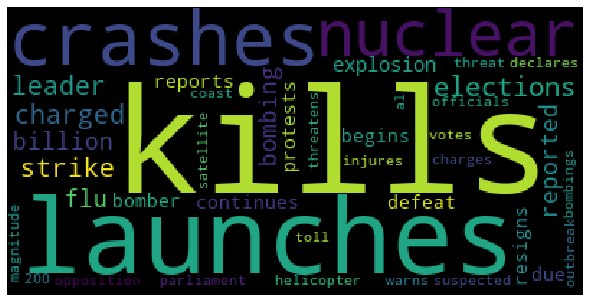

In [14]:
wordcloud  = WordCloud(min_font_size=10).generate_from_frequencies(dict(difference_frequency))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## Visualize the Intersection Between the Classes

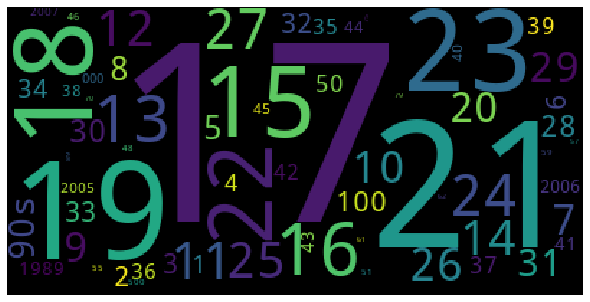

In [15]:
# Visualize the intersection between the two corpus

click_diff = {}
for word in overlap:
    click_diff[word] = countX(click_tokenized, word)

difference_frequency = sorted(click_diff.items(), reverse=True, key = (lambda x: x[1]))
wordcloud  = WordCloud(min_font_size=5).generate_from_frequencies(dict(difference_frequency))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Wow. Every overlapping string is actually a number. This begs the question, what proportion of each of the classes are numerical? If the overlapping words 

In [16]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

# I think we have seen enough to run a simple Naive Bayes Classifier.

- tf-idf into a sparse matrix
    - There are A LOT of features to play with in the Vectorizer. All should be gridsearched
    - vectorizer is producing a matrix of 1,1 but I want 
- run model

In [17]:
tfidf_ = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1))

In [18]:
X_train_tfidf = tfidf_.fit_transform(X_train.text)
X_test_tfidf = tfidf_.transform(X_test.text)

In [19]:
clf = BernoulliNB()
clf.fit(X_train_tfidf, y_train)
y_hat = clf.predict(X_test_tfidf)

accuracy_score(y_test, y_hat)

0.96171875

In [20]:
f1_score(y_test, y_hat)

0.9621153548786144

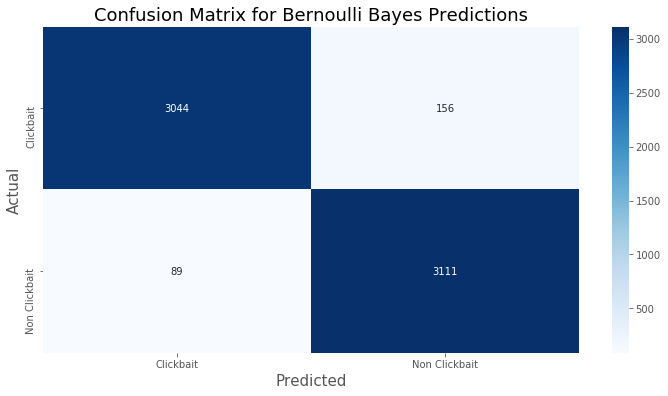

In [28]:

def plot_cmatrix(actual, predictions):
    '''Takes in arrays of actual binary values and model predictions and generates and plots a confusion matrix'''
    cmatrix = confusion_matrix(actual, predictions)

    fig, ax = plt.subplots(figsize = (12,6))
    sns.heatmap(cmatrix, annot=True, fmt='g', ax=ax, cmap='Blues')
    ax.set_xticklabels(['Clickbait', 'Non Clickbait'])
    ax.set_yticklabels(['Clickbait', 'Non Clickbait'])
    ax.set_ylabel('Actual', size=15)
    ax.set_xlabel('Predicted', size=15)
    ax.set_title('Confusion Matrix for Bernoulli Bayes Predictions', size =18)
    

plot_cmatrix(y_test, y_hat)

In [22]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)

In [23]:
rf_classifier.fit(X_train_tfidf, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [24]:
y_hat_rf = rf_classifier.predict(X_test_tfidf)

In [25]:
accuracy_score(y_test, y_hat_rf)


0.92453125

In [26]:
X_train_tfidf.shape

(25600, 20765)

# Now that I have a baseline model/I need to apply the same methods to the other two data frames.

If they perform similarly, I can start thinking about takin the model into production.

Next steps:
- train test and holdout
- testing the current model on unseeen data fromn other data sets
- 